In [1]:
#default_exp style_transfer

Before we run anything we want to ensure we have a P100 GPU:

In [62]:
!nvidia-smi

Sun Feb 16 20:01:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   49C    P0    24W /  75W |   1853MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

If not, run the following:

(NOTE: This may change due to Colab's new policy)

In [63]:
import torch
# data = torch.ones(1000,1000,1000).cuda()

# 05 - Style Transfer
**This notebook is largely based on the work by Lucas Vazquez on the fastai forum**

## What will we cover?

* Custom loss functions
* Custom models
* Utilizing the `nb_dev` library
* Deployment Code

# Intro to `nbdev`

* Library by Jeremy and Sylvain for writing libraries
* Used to make the entire `fastai2` library
* Converts a `ipynb` to documentation as well as `.py` with **only specific cells**

* Few base terminology:
  * `#default_exp`
  * `#hide`
  * `#export`

In [64]:
#hide
#Run once per session
# import os
# !pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
# !pip install torch==1.3.1
# !pip install torchvision==0.4.2
# !pip install Pillow==6.2.1 --upgrade
# os._exit(00)

In [65]:
#hide
from nbdev.showdoc import *

We always need the `showdoc` to export

# fastai2 libraries

In [66]:
#export
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# What is Style Transfer?

* **Feature Loss**
  * Aka perception loss
* **Image Transformation network**
  * Input images -> Output images
* **Pre-Trained Loss Network**
  * **Perceptual loss functions** 
    * A measurement of the differences in content and style between two images
    
![alt text](https://miro.medium.com/max/1436/0*iwXnji_6lny5slPo)

Source: https://arxiv.org/abs/1603.08155

# Our Pre-Trained Network:
* vgg-19:
  * Small CNN pre-trained on ImageNet
  * Only 19 layers deep

In [67]:
#export
from torchvision.models import vgg19, vgg16

In [68]:
base19 = vgg19(pretrained=True)

In [69]:
type(base19)

torchvision.models.vgg.VGG

In [70]:
base19_features = base19.features

In [71]:
base19_features[:4], ' ... ', base19_features[-4:]

(Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
 ),
 ' ... ',
 Sequential(
   (33): ReLU(inplace=True)
   (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (35): ReLU(inplace=True)
   (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ))

In [72]:
type(base19_features)

torch.nn.modules.container.Sequential

In [73]:
from IPython.display import display, Markdown, Latex, HTML

In [74]:
display(HTML(torch.nn.modules.container.Sequential.eval.__doc__))

In [75]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

We'll get rid of the head and use the internal activations (and our generator model's loss). As a result, we want to set every layer to un-trainable

In [76]:
for p in feat_net.parameters(): p.requries_grad=False

We will be using feature detections that our model picks up, which is like our heatmaps generated for our Classification models

In [77]:
layers = [feat_net[i] for i in [1, 6, 11, 20, 29, 22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

The outputs are `ReLU` layers. Below is a configuration for the 16 and 19 models

In [78]:
#export
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

Let's write a quick `get_layers` function to grab our network and the layers

In [79]:
#export 
def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
  feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
  config = _vgg_config.get(arch)
  features = feat_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return feat_net, [features[i] for i in config]

Now let's make it all in one go utilizing our private functions to pass in an architecture name and a `pretrained` parameter

In [80]:
#export
def get_feats(arch:str, pretrained=True):
  "Get the features of an architecture"
  feat_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_net(x)
    return hooks.stored
  return _inner

In [81]:
feats = get_feats('vgg19')

In [82]:
type(feats)

function

# The Loss Function


Our loss fuction needs:

* Our original image
* Some artwork / style
* Activation features from our encoder

What image will we be using?

![alt text](https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg)

Let's grab the image

In [83]:
#export
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

In [84]:
!wget {url} -O 'style.jpg'

--2020-02-16 20:01:50--  https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg
Resolving static.greatbigcanvas.com (static.greatbigcanvas.com)... 52.73.94.154, 3.212.96.207
Connecting to static.greatbigcanvas.com (static.greatbigcanvas.com)|52.73.94.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445921 (435K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 435.47K  --.-KB/s    in 0.1s    

2020-02-16 20:01:51 (3.53 MB/s) - ‘style.jpg’ saved [445921/445921]



In [85]:
fn = 'style.jpg'

We can now make a `PipeLine` to convert our image into a `Tensor` to use in our loss function. We'll want to use the `Datasets` for this

##### Reading in images

In [86]:
import PIL

In [87]:
pil_img = PIL.Image.open(fn)

print(type(pil_img))

np_img = np.asarray(PIL.Image.open(fn))

print(type(np_img))
print(np_img.shape)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
(824, 1000, 3)


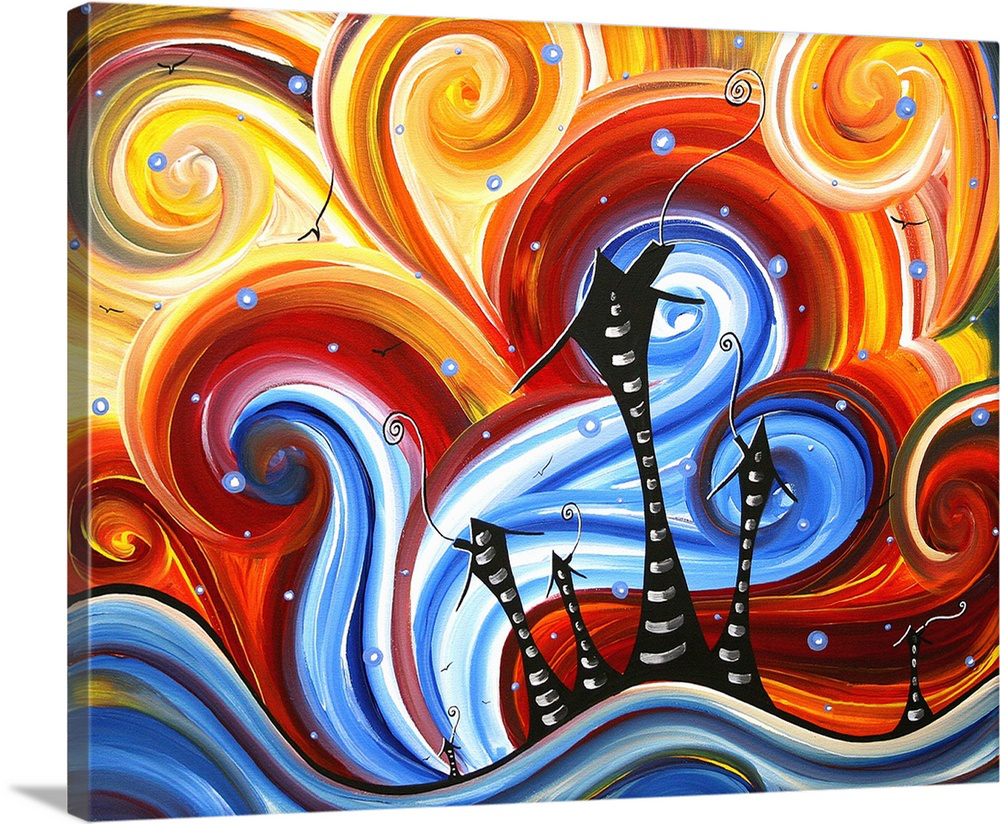

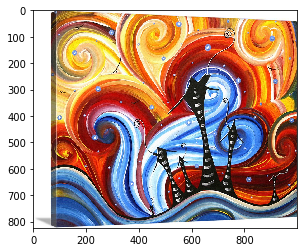

In [88]:
plt.imshow(np_img)
# plt.imshow(pil_img)
pil_img

In [89]:
dset = Datasets(fn, tfms=[PILImage.create])

In [90]:
type(dset)

fastai2.data.core.Datasets

In [91]:
import fastai2

In [92]:
dl = dset.dataloaders( after_item=[ToTensor()], 
                       after_batch=[
                               IntToFloatTensor(), 
                               Normalize.from_stats(*imagenet_stats)
                               ], 
                       bs=1)

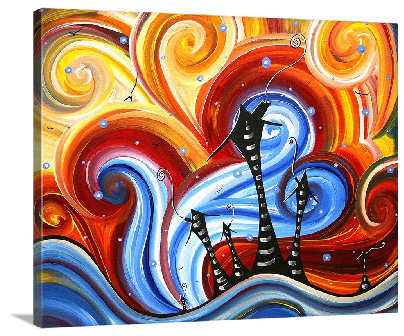

In [93]:
dl.show_batch(figsize=(7,7))

In [94]:
style_im = dl.one_batch()[0]

In [95]:
style_im.shape

torch.Size([1, 3, 824, 1000])

In [96]:
type(style_im)

fastai2.torch_core.TensorImage

In [97]:
#export
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
  return dl.one_batch()[0]

We can then grab the features using our `feats` function we made earlier

In [98]:
im_feats = feats(style_im)

Let's look at their sizes

In [99]:
for feat in im_feats:
  print(feat.shape)

torch.Size([1, 64, 824, 1000])
torch.Size([1, 128, 412, 500])
torch.Size([1, 256, 206, 250])
torch.Size([1, 512, 103, 125])
torch.Size([1, 512, 51, 62])
torch.Size([1, 512, 103, 125])


Now we can bring those images down to the channel size

In [100]:
#export
def gram(x:Tensor):
  "Transpose a tensor based on c,w,h"
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)

In [101]:
im_grams = [gram(f) for f in im_feats]

In [102]:
for feat in im_grams:
  print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [103]:
#export
def get_stl_fs(fs): return fs[:-1]

We're almost there! Let's look at why that was important

In [104]:
#export
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000
  return 3e5 * sum(loss)

Great, so what now? Let's make a loss function for `fastai2`!
* Remember, we do not care to use any initial metrics

In [105]:
Module.__doc__

'Same as `nn.Module`, but no need for subclasses to call `super().__init__`'

In [106]:
#export
class FeatureLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, feats, style_loss, act_loss):
    store_attr(self, 'feats, style_loss, act_loss')
    self.reset_metrics()

  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_feat, targ_feat = self.feats(pred), self.feats(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_feat, targ_feat)
    act_loss = self.act_loss(pred_feat, targ_feat)
    # Store the loss
    self._add_loss(style_loss, act_loss)
    # Return the sum
    return style_loss + act_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, act_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(act_loss)

In [107]:
#export
def act_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

Let's declare our loss function by passing in our features and our two 'mini' loss functions

In [108]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

# The Model Architecture
Let's now build our model

In [109]:
#export
class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [110]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
)

In [111]:
#export
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out

In [112]:
ResidualBlock(3)

ResidualBlock(
  (conv1): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU()
)

In [113]:
#export
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

Let's put everything together into a model

In [114]:
#export
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [115]:
net = TransformerNet()

# DataLoaders and Learner

We will be using the `COCO_SAMPLE` dataset

In [116]:
path = untar_data(URLs.COCO_SAMPLE)

Our `DataBlock` needs to be Image -> Image

In [117]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [118]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

If you do not pass in a `get_y`, `fastai2` will assume your input = output

In [119]:
dls = dblock.dataloaders(path, bs=4)

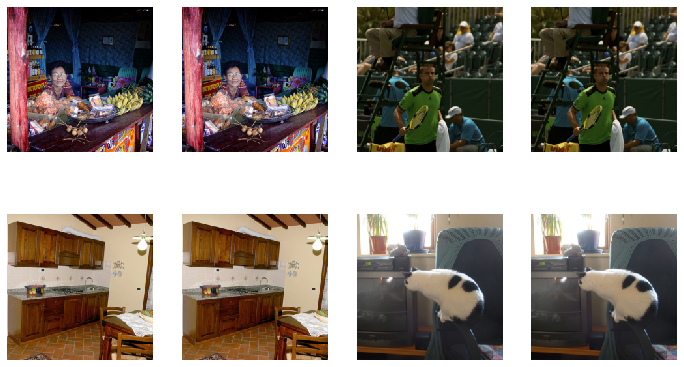

In [120]:
dls.show_batch()

We now can make our `Learner`!

In [121]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

In [122]:
learn.summary()

TransformerNet (Input shape: ['4 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
ReflectionPad2d      4 x 3 x 232 x 232    0          False     
________________________________________________________________
Conv2d               4 x 32 x 224 x 224   7,808      True      
________________________________________________________________
InstanceNorm2d       4 x 32 x 224 x 224   64         True      
________________________________________________________________
ReflectionPad2d      4 x 32 x 226 x 226   0          False     
________________________________________________________________
Conv2d               4 x 64 x 112 x 112   18,496     True      
________________________________________________________________
InstanceNorm2d       4 x 64 x 112 x 112   128        True      
________________________________________________________________
ReflectionPad2d      4 x 64 x 114 x 114   0          False     
______________________________________________

Let's find a learning rate and fit for one epoch

(0.0007585775572806596, 0.0020892962347716093)

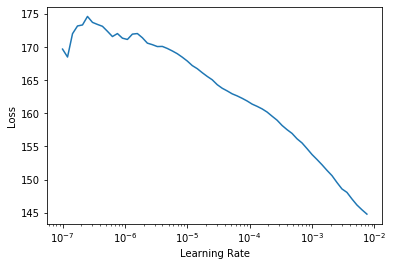

In [123]:
learn.lr_find()

In [124]:
learn.fit_one_cycle(1, 1e-3)

In [0]:
# learn.fit_one_cycle(1, 1e-3)

And take a look at some of our results!

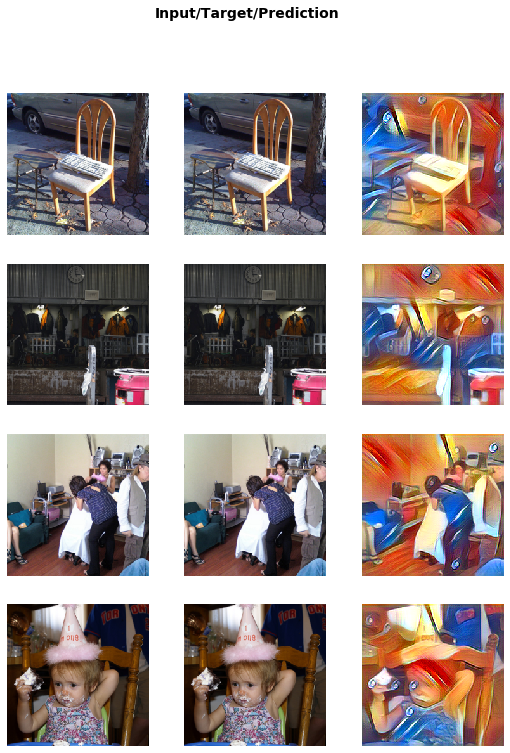

In [125]:
learn.show_results()

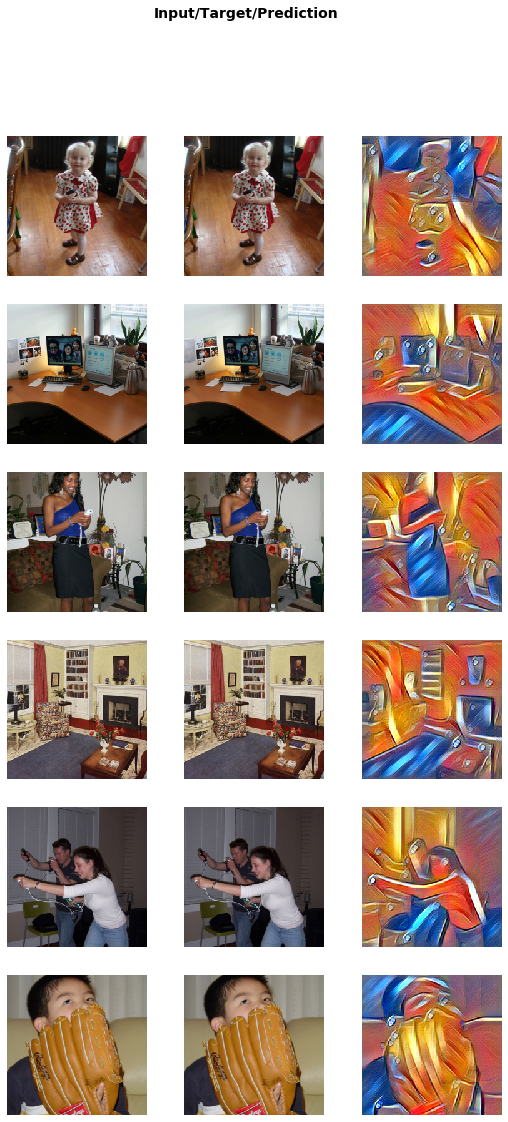

In [0]:
# learn.show_results()

In [126]:
learn.save('stage1')

Now let's try `learn.predict`

In [127]:
# pred = learn.predict('cat.jpg')

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai2-aug/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/envs/fastai2-aug/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/load.py", line 106, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/utils.py", line 268, in chunked
    res = list(itertools.islice(it, cs))
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/load.py", line 119, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/load.py", line 125, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/core.py", line 265, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/core.py", line 265, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/core.py", line 242, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/data/core.py", line 206, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/transform.py", line 188, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/transform.py", line 136, in compose_tfms
    x = f(x, **kwargs)
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/transform.py", line 71, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/transform.py", line 82, in _call
    if self.use_as_item or not is_listy(x): return self._do_call(f, x, **kwargs)
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/transform.py", line 87, in _do_call
    return x if f is None else retain_type(f(x, **kwargs), x, f.returns_none(x))
  File "/home/jupyter/fastai2-dev/fastcore/fastcore/dispatch.py", line 98, in __call__
    return f(*args, **kwargs)
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/vision/core.py", line 90, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/home/jupyter/fastai2-dev/fastai2/fastai2/vision/core.py", line 74, in load_image
    im = Image.open(fn, **kwargs)
  File "/opt/anaconda3/envs/fastai2-aug/lib/python3.7/site-packages/PIL/Image.py", line 2766, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'cat.jpg'


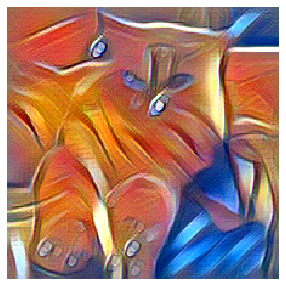

In [0]:
pred[0].show()

Well while that looks cool, we lost a lot of the features! How can we fix this? Let's try something similar to what we did for our `style_im`

In [43]:
learn.load('stage1')

In [0]:
dset = Datasets('cat.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

In [0]:
t_im = dl.one_batch()[0]

In [0]:
with torch.no_grad():
  res = learn.model(t_im)

Now let's try that again

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


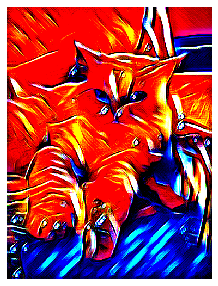

In [63]:
TensorImage(res[0]).show()

Much better!

In [0]:
learn.save('224')

Now we can increase our size to 512 similar to how we could do in the segmentation example (this is homework, we will not do this as the epoch will take ~40 minutes)

# Homework

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(448)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = dblock.dataloaders(path, bs=8)

In [0]:
learn = Learner(dls, net, loss_func=loss_func).load('224')

In [0]:
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.show_results()

In [0]:
learn.save('final')

# Rest of the lesson

Let's export our model to use.

In [0]:
learn.loss_func = CrossEntropyLossFlat()

In [0]:
learn.export('myModel')

From here:
Download the notebook and upload it to the main

# Export

In [ ]:
create_config()

In [3]:
#hide
from nbdev.imports import *
from nbdev.export import reset_nbdev_module, notebook2script

create_config('myLib', user='muellerzr', path='.', cfg_name='settings.ini')
cfg = Config(cfg_name='settings.ini')

In [10]:
reset_nbdev_module()

In [8]:
#hide
from nbdev.export import notebook2script

In [12]:
!ls

01_Custom.ipynb			   04_Multi_Label.ipynb
01_Pets.ipynb			   04_Segmentation.ipynb
01_Slides.pdf			   05_EfficientNet_and_Custom_Weights.ipynb
01_Slides.pptx			   05_Inference_Server.ipynb
02_Deployment.ipynb		   05_Style_Transfer.ipynb
02_MNIST.ipynb			   06_Keypoint_Regression.ipynb
02_SGD.ipynb			   06_Object_Detection.ipynb
03_Cross_Validation.ipynb	   imports
03_Internal_API_Walkthrough.ipynb  models
03_Multi_Label.ipynb		   myLib
03_Unknown_Labels.ipynb		   settings.ini
04_DBlock_Summary.ipynb		   style.jpg
04_ImageWoof.ipynb		   Untitled.ipynb


In [11]:
notebook2script('05_StyleTransfer.ipynb')

In [ ]:
notebook2script()